📂 Reading match files from: /Users/user/XG/Eredivisie 2025-2026
Found 113 JSON files in folder.



Loading JSON files: 100%|██████████| 113/113 [00:04<00:00, 26.18it/s]


✅ Loaded 187193 total events from 113 matches

Events shape: (187193, 289)
Matches shape: (113, 7)
✅ Computed xTT for 187080 events.

📊 Generating example heatmaps...



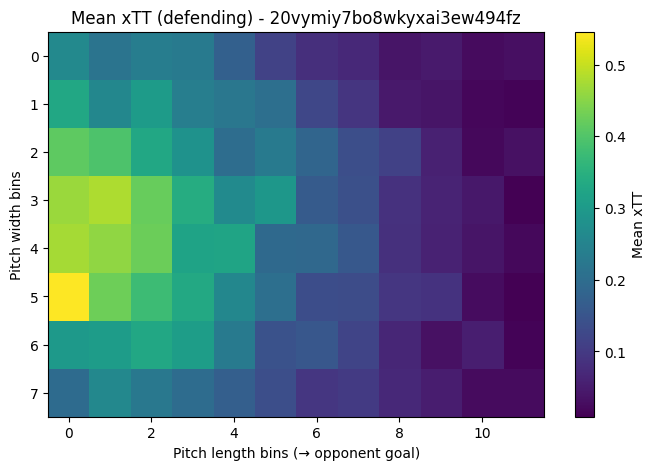

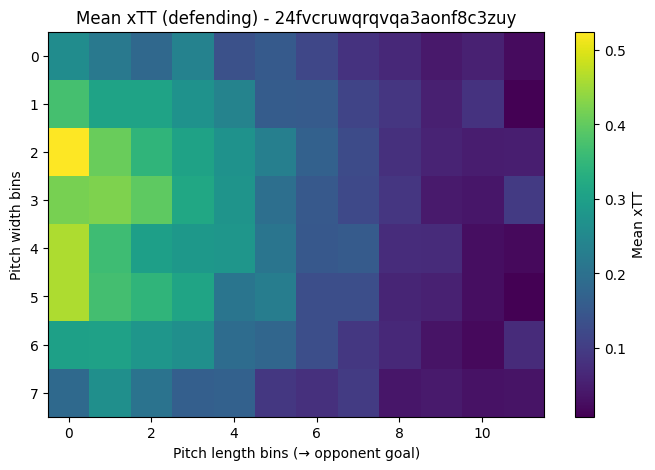

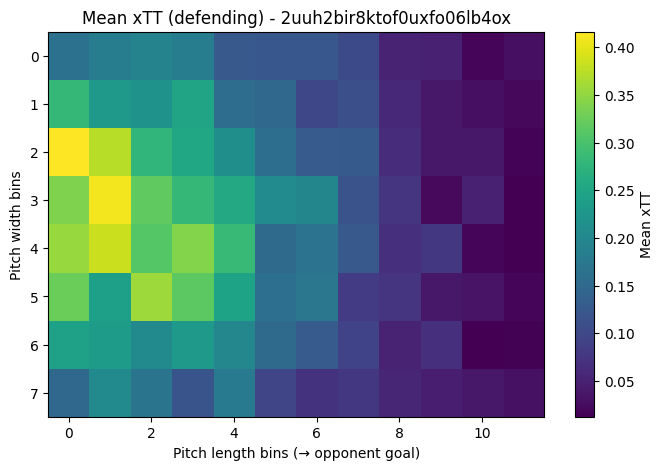

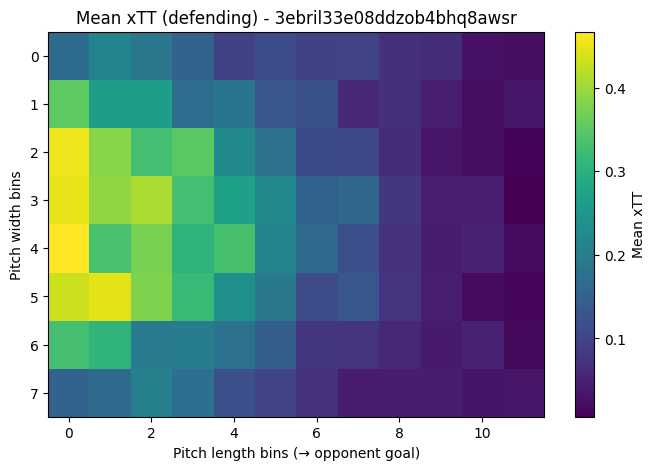

✅ Saved all outputs to:
  • /Users/user/XG/NL/all_matches_events.csv
  • /Users/user/XG/NL/all_matches_metadata.csv
  • /Users/user/XG/NL/xTT_per_event.csv
  • /Users/user/XG/NL/xTT_binned.csv


In [1]:
# ============================================================
# ⚽️ Football Match JSON Loader + Expected Transition Threat (xTT)
#   - Local Version (no Google Colab / Google Drive)
#   - Reads all .json match files from a local folder
#   - Extracts event-level and match metadata
#   - Computes Expected Transition Threat (xTT)
#   - Saves CSVs + heatmaps locally
# ============================================================

import os, json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# ============================================================
# 1️⃣ Path configuration
# ============================================================

# Change these two paths for your local setup
json_folder = r"/Users/user/XG/Eredivisie 2025-2026"   # Folder with JSON files
out_dir = r"/Users/user/XG/NL"          # Folder for results

os.makedirs(out_dir, exist_ok=True)

# Verify folder exists
if not os.path.exists(json_folder):
    raise FileNotFoundError(f"Folder not found: {json_folder}")

print(f"📂 Reading match files from: {json_folder}")

# ============================================================
# 2️⃣ Load and flatten all JSONs
# ============================================================

all_events = []
all_matches = []

json_files = [f for f in os.listdir(json_folder) if f.endswith(".json")]
print(f"Found {len(json_files)} JSON files in folder.\n")

for file in tqdm(json_files, desc="Loading JSON files"):
    fpath = os.path.join(json_folder, file)
    try:
        with open(fpath, "r", encoding="utf-8") as f:
            data = json.load(f)
    except Exception as e:
        print(f"⚠️ Failed to load {file}: {e}")
        continue

    # --- Extract match details ---
    match_info = data.get("matchDetails", {})
    match_record = {
        "source_file": file,
        "home_goals": match_info.get("scores", {}).get("ft", {}).get("home"),
        "away_goals": match_info.get("scores", {}).get("ft", {}).get("away"),
        "winner": match_info.get("winner"),
        "matchLengthMin": match_info.get("matchLengthMin"),
        "matchLengthSec": match_info.get("matchLengthSec"),
        "status": match_info.get("matchStatus")
    }
    all_matches.append(match_record)

    # --- Extract events ---
    events = data.get("event", [])
    for e in events:
        e["source_file"] = file
        if "qualifier" in e and isinstance(e["qualifier"], list):
            for q in e["qualifier"]:
                qid = q.get("qualifierId")
                val = q.get("value")
                if qid is not None:
                    e[f"qualifier_{qid}"] = val
            del e["qualifier"]
        all_events.append(e)

print(f"✅ Loaded {len(all_events)} total events from {len(json_files)} matches\n")

# ============================================================
# 3️⃣ Convert to DataFrames
# ============================================================

events_df = pd.json_normalize(all_events, sep="_")
matches_df = pd.DataFrame(all_matches)

print("Events shape:", events_df.shape)
print("Matches shape:", matches_df.shape)

# ============================================================
# 4️⃣ Basic cleaning
# ============================================================

for c in ['x', 'y', 'timeMin', 'timeSec']:
    if c not in events_df.columns:
        events_df[c] = np.nan

events_df['t'] = events_df['timeMin'] * 60 + events_df['timeSec']

# ============================================================
# 5️⃣ Compute simple xT-like field value
# ============================================================

def simple_xt_value(x, y):
    x = np.clip(x, 0, 100)
    y = np.clip(y, 0, 100)
    x_term = (x / 100.0) ** 2
    y_term = np.exp(-((y - 50.0) ** 2) / (2 * (22.0 ** 2)))  # center bias
    return float(x_term * y_term)

events_df['xT'] = events_df.apply(
    lambda r: simple_xt_value(r.get('x', np.nan), r.get('y', np.nan)), axis=1
)

# ============================================================
# 6️⃣ Expected Transition Threat (xTT)
# ============================================================

def compute_xTT(df_match):
    """Compute xTT per event for one match"""
    if 'contestantId' not in df_match.columns:
        return pd.DataFrame()

    teams = df_match['contestantId'].dropna().unique().tolist()
    if len(teams) < 2:
        return pd.DataFrame()
    teamA, teamB = teams[0], teams[1]

    df_match = df_match.sort_values('t').reset_index(drop=True)
    records = []

    def next_regain_and_value(idx, defending_team, horizon_regain=5.0, horizon_attack=10.0):
        row = df_match.iloc[idx]
        t0 = row['t']
        mask_window = (df_match.index > idx) & (df_match['t'] <= t0 + horizon_regain)
        next_by_def = df_match[mask_window & (df_match['contestantId'] == defending_team)]
        if next_by_def.empty:
            return 0.0, np.nan, np.nan
        regain_idx = int(next_by_def.index[0])
        t_regain = float(df_match.loc[regain_idx, 't'])
        attack_window = (
            (df_match.index >= regain_idx)
            & (df_match['t'] <= t_regain + horizon_attack)
            & (df_match['contestantId'] == defending_team)
        )
        attack_value = float(df_match[attack_window]['xT'].max()) if not df_match[attack_window].empty else 0.0
        return 1.0, t_regain - t0, attack_value

    for idx in range(len(df_match) - 1):
        team_in_poss = df_match.iloc[idx]['contestantId']
        if team_in_poss not in teams:
            continue
        team_def = teamB if team_in_poss == teamA else teamA
        x, y = df_match.iloc[idx]['x'], df_match.iloc[idx]['y']
        if np.isnan(x) or np.isnan(y):
            continue
        regained, dt, attack_val = next_regain_and_value(idx, team_def, 5.0, 10.0)
        xTT = float(regained * attack_val)
        records.append({
            'event_idx': idx,
            'match_file': df_match.iloc[idx]['source_file'],
            'def_team': team_def,
            'att_team': team_in_poss,
            't': df_match.iloc[idx]['t'],
            'x': x, 'y': y,
            'regained_within_5s': bool(regained),
            'time_to_regain_s': dt if not np.isnan(dt) else None,
            'attack_value_10s': attack_val if not np.isnan(attack_val) else 0.0,
            'xTT': xTT
        })

    return pd.DataFrame.from_records(records)

# ============================================================
# 7️⃣ Run xTT for all matches
# ============================================================

xTT_frames = []
for file, match_df in events_df.groupby("source_file"):
    xTT_part = compute_xTT(match_df)
    if not xTT_part.empty:
        xTT_frames.append(xTT_part)

xTT_df = pd.concat(xTT_frames, ignore_index=True)
print(f"✅ Computed xTT for {len(xTT_df)} events.\n")

# ============================================================
# 8️⃣ Aggregate to heatmaps
# ============================================================

x_bins = np.linspace(0, 100, 13)
y_bins = np.linspace(0, 100, 9)
xTT_df['x_bin'] = pd.cut(xTT_df['x'], bins=x_bins, labels=False, include_lowest=True)
xTT_df['y_bin'] = pd.cut(xTT_df['y'], bins=y_bins, labels=False, include_lowest=True)

heat = xTT_df.groupby(['def_team', 'x_bin', 'y_bin']).agg(
    events=('xTT', 'size'),
    regain_rate=('regained_within_5s', 'mean'),
    mean_attack_value=('attack_value_10s', 'mean'),
    mean_xTT=('xTT', 'mean')
).reset_index()

# ============================================================
# 9️⃣ Plot heatmaps for first few teams
# ============================================================

def plot_xtt_heat(team_id, heat_df, title):
    grid = np.full((8, 12), np.nan)
    sub = heat_df[heat_df['def_team'] == team_id]
    for _, r in sub.iterrows():
        xb, yb = int(r['x_bin']), int(r['y_bin'])
        if 0 <= xb < 12 and 0 <= yb < 8:
            grid[7 - yb, xb] = r['mean_xTT']
    plt.figure(figsize=(8, 5))
    plt.imshow(grid, aspect='auto', interpolation='nearest')
    plt.title(title)
    plt.xlabel('Pitch length bins (→ opponent goal)')
    plt.ylabel('Pitch width bins')
    plt.colorbar(label='Mean xTT')
    plt.show()

print("📊 Generating example heatmaps...\n")
for t in heat['def_team'].unique()[:4]:
    plot_xtt_heat(t, heat, f"Mean xTT (defending) - {t}")

# ============================================================
# 🔟 Save results locally
# ============================================================

out_events  = os.path.join(out_dir, "all_matches_events.csv")
out_matches = os.path.join(out_dir, "all_matches_metadata.csv")
out_xtt     = os.path.join(out_dir, "xTT_per_event.csv")
out_heat    = os.path.join(out_dir, "xTT_binned.csv")

events_df.to_csv(out_events, index=False)
matches_df.to_csv(out_matches, index=False)
xTT_df.to_csv(out_xtt, index=False)
heat.to_csv(out_heat, index=False)

print("✅ Saved all outputs to:")
print("  •", out_events)
print("  •", out_matches)
print("  •", out_xtt)
print("  •", out_heat)


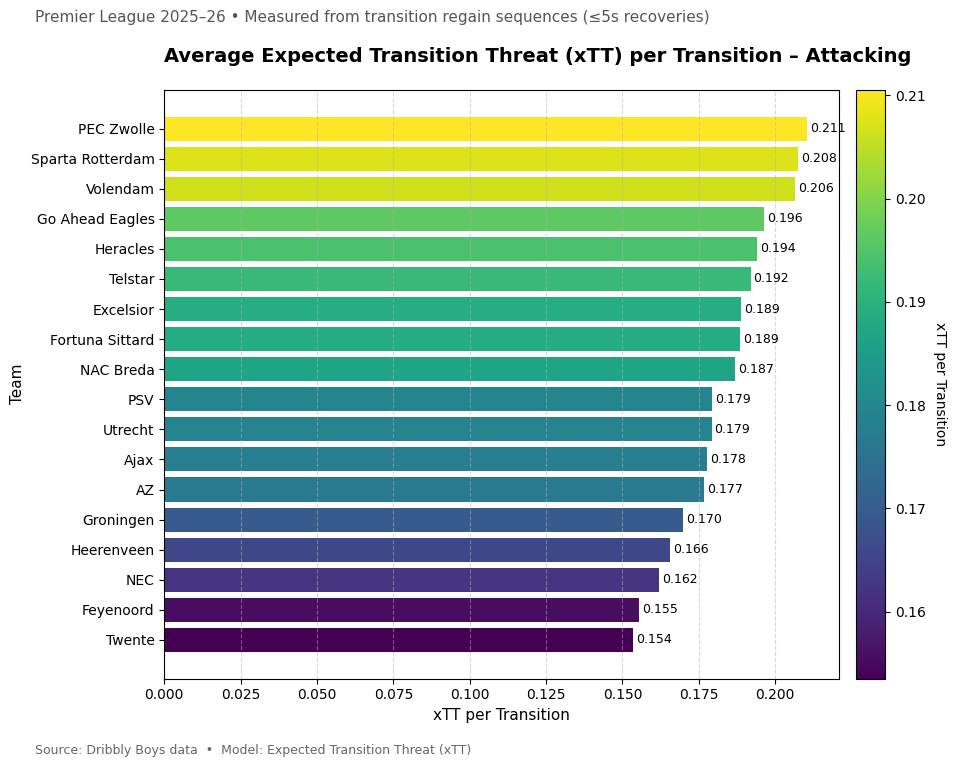

✅ Saved styled horizontal bar chart to: /Users/user/xTT_per_transition_barh_styled.png

📋 Top teams by xTT per Transition:


,Team,xTT_per_transition,n_transitions,total_xTT
2,PEC Zwolle,0.210533,5423,1141.719180
9,Sparta Rotterdam,0.207557,5599,1162.112408
8,Volendam,0.206469,5378,1110.392438
11,Go Ahead Eagles,0.196440,5148,1011.273419
15,Heracles,0.194061,5519,1071.023814
17,Telstar,0.191946,5598,1074.516344
16,Excelsior,0.188907,6076,1147.797374
3,Fortuna Sittard,0.188518,5859,1104.527032
7,NAC Breda,0.186771,6209,1159.661681
1,PSV,0.179393,6175,1107.754391


In [2]:
# ============================================================
# 📊 xTT per Transition (Attacking) — Styled Horizontal Bar Chart
# ============================================================

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl

# ============================================================
# 1️⃣ Load team mapping file
# ============================================================

# 🔧 Update this path to your local file
teams_path = "/Users/user/XG/Eredivisie 2025-2026 Matches.csv"

teams_df = pd.read_csv(teams_path)

# Build mapping: contestantId → Team name
team_map = dict(zip(
    teams_df["matchInfo/contestant/0/id"],
    teams_df["matchInfo/contestant/0/name"]
))
if "matchInfo/contestant/1/id" in teams_df.columns and "matchInfo/contestant/1/name" in teams_df.columns:
    team_map.update(dict(zip(
        teams_df["matchInfo/contestant/1/id"],
        teams_df["matchInfo/contestant/1/name"]
    )))

# ============================================================
# 2️⃣ Compute per-transition attacking xTT
# ============================================================

# Make sure xTT_df exists (e.g., loaded from your previous script)
# Example: xTT_df = pd.read_csv("/Users/user/PL_Outputs/xTT_per_event.csv")

xtt_attack = (
    xTT_df.groupby("att_team")
    .agg(
        total_xTT=("xTT", "sum"),
        n_transitions=("regained_within_5s", lambda s: s.sum())  # number of regains
    )
    .reset_index()
)

# Avoid division by zero
xtt_attack = xtt_attack[xtt_attack["n_transitions"] > 0]

xtt_attack["xTT_per_transition"] = xtt_attack["total_xTT"] / xtt_attack["n_transitions"]
xtt_attack["Team"] = xtt_attack["att_team"].map(team_map)
xtt_attack = xtt_attack.dropna(subset=["Team"])
xtt_attack = xtt_attack.sort_values("xTT_per_transition", ascending=True)

# ============================================================
# 3️⃣ Plot with color gradient
# ============================================================

fig, ax = plt.subplots(figsize=(10, 8))

# Normalize color scale to values
norm = mpl.colors.Normalize(
    vmin=xtt_attack["xTT_per_transition"].min(),
    vmax=xtt_attack["xTT_per_transition"].max()
)
cmap = plt.cm.viridis
colors = cmap(norm(xtt_attack["xTT_per_transition"].values))

# Create bars
bars = ax.barh(
    xtt_attack["Team"],
    xtt_attack["xTT_per_transition"],
    color=colors,
    edgecolor="none"
)

# ============================================================
# 4️⃣ Annotate values on bars
# ============================================================

for i, (val, team) in enumerate(zip(xtt_attack["xTT_per_transition"], xtt_attack["Team"])):
    ax.text(val + 0.001, i, f"{val:.3f}", va="center", fontsize=9, color="black")

# ============================================================
# 5️⃣ Title, subtitle, and source
# ============================================================

ax.set_title(
    "Average Expected Transition Threat (xTT) per Transition – Attacking",
    fontsize=14,
    fontweight="bold",
    loc="left",
    pad=20
)

fig.suptitle(
    "Premier League 2025–26 • Measured from transition regain sequences (≤5s recoveries)",
    fontsize=11,
    x=0.04,
    y=0.94,
    ha='left',
    color="#555555"
)

fig.text(
    0.04,
    0.01,
    "Source: Dribbly Boys data  •  Model: Expected Transition Threat (xTT)",
    fontsize=9,
    color="#666666",
    ha="left"
)

# ============================================================
# 6️⃣ Style axes and layout
# ============================================================

ax.set_xlabel("xTT per Transition", fontsize=11)
ax.set_ylabel("Team", fontsize=11)
ax.grid(axis="x", linestyle="--", alpha=0.5)
ax.tick_params(axis='y', labelsize=10)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])

# ============================================================
# 7️⃣ Add colorbar (fixed attachment)
# ============================================================

sm = mpl.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

# ✅ Properly attach colorbar to the same axis
cbar = fig.colorbar(sm, ax=ax, orientation="vertical", pad=0.02)
cbar.set_label("xTT per Transition", rotation=270, labelpad=15)

# ============================================================
# 8️⃣ Show and Save chart
# ============================================================

plt.show()

out_bar = "/Users/user/xTT_per_transition_barh_styled.png"
fig.savefig(out_bar, dpi=300, bbox_inches="tight")
print(f"✅ Saved styled horizontal bar chart to: {out_bar}")

# ============================================================
# 9️⃣ Display numeric summary table
# ============================================================

print("\n📋 Top teams by xTT per Transition:")
display(
    xtt_attack[["Team", "xTT_per_transition", "n_transitions", "total_xTT"]]
        .sort_values("xTT_per_transition", ascending=False)
)


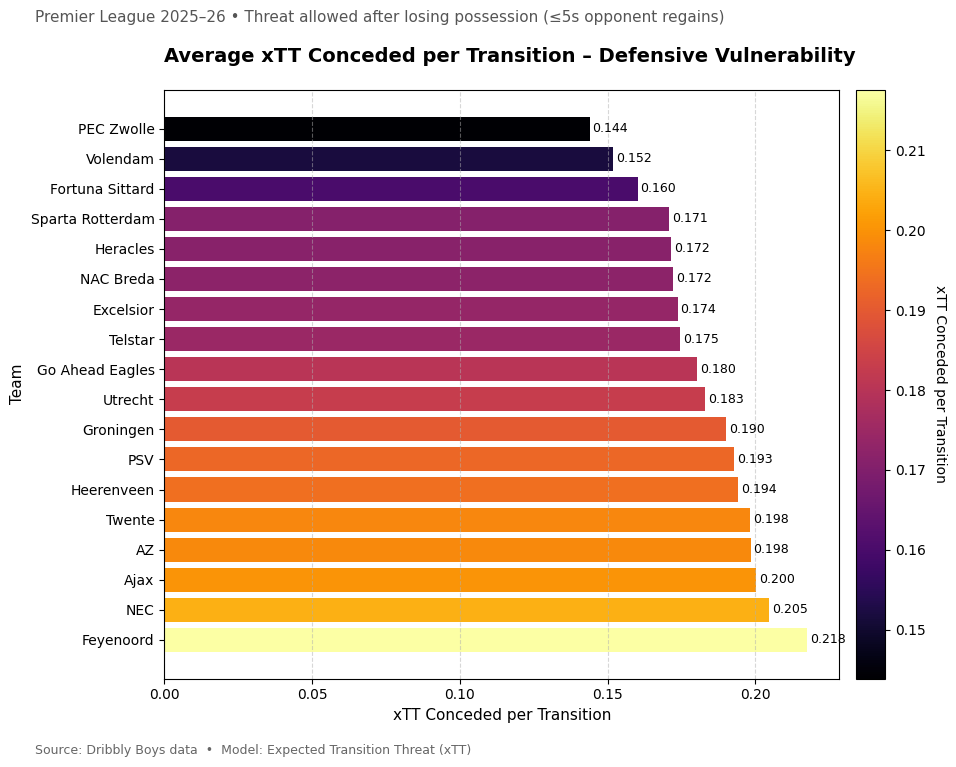

✅ Saved defensive vulnerability chart to: /Users/user/xTT_conceded_per_transition_barh.png

📋 Teams most vulnerable in transition (highest xTT conceded):


,Team,xTT_conceded_per_transition,n_transitions_conceded,total_xTT_conceded
0,Feyenoord,0.217542,5627,1224.106371
10,NEC,0.204530,5925,1211.837331
14,Ajax,0.200133,5661,1132.953306
4,AZ,0.198331,5520,1094.785674
5,Twente,0.198222,6327,1254.152326
6,Heerenveen,0.194219,5810,1128.410215
1,PSV,0.192661,6202,1194.882529
13,Groningen,0.190039,6037,1147.266982
12,Utrecht,0.182928,5656,1034.643188
11,Go Ahead Eagles,0.180333,5254,947.470158


In [3]:
# ============================================================
# 🚨 xTT Conceded per Transition (Defensive Vulnerability)
# ============================================================

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl

# --- 1️⃣ Load team mapping file (same as before)
teams_path = "/Users/user/XG/Eredivisie 2025-2026 Matches.csv"
teams_df = pd.read_csv(teams_path)

team_map = dict(zip(
    teams_df["matchInfo/contestant/0/id"],
    teams_df["matchInfo/contestant/0/name"]
))
if "matchInfo/contestant/1/id" in teams_df.columns and "matchInfo/contestant/1/name" in teams_df.columns:
    team_map.update(dict(zip(
        teams_df["matchInfo/contestant/1/id"],
        teams_df["matchInfo/contestant/1/name"]
    )))

# --- 2️⃣ Compute per-transition defensive xTT conceded
# Each row = an event where one team lost the ball and the opponent created xTT
xtt_conceded = (
    xTT_df.groupby("def_team")
    .agg(
        total_xTT_conceded=("xTT", "sum"),
        n_transitions_conceded=("regained_within_5s", lambda s: s.sum())  # opponent regains
    )
    .reset_index()
)

# Avoid division by zero
xtt_conceded = xtt_conceded[xtt_conceded["n_transitions_conceded"] > 0]

xtt_conceded["xTT_conceded_per_transition"] = (
    xtt_conceded["total_xTT_conceded"] / xtt_conceded["n_transitions_conceded"]
)
xtt_conceded["Team"] = xtt_conceded["def_team"].map(team_map)
xtt_conceded = xtt_conceded.dropna(subset=["Team"])
xtt_conceded = xtt_conceded.sort_values("xTT_conceded_per_transition", ascending=False)

# --- 3️⃣ Plot vulnerability chart
fig, ax = plt.subplots(figsize=(10, 8))

norm = mpl.colors.Normalize(
    vmin=xtt_conceded["xTT_conceded_per_transition"].min(),
    vmax=xtt_conceded["xTT_conceded_per_transition"].max()
)
cmap = plt.cm.inferno
colors = cmap(norm(xtt_conceded["xTT_conceded_per_transition"].values))

bars = ax.barh(
    xtt_conceded["Team"],
    xtt_conceded["xTT_conceded_per_transition"],
    color=colors,
    edgecolor="none"
)

# --- 4️⃣ Annotate values
for i, (val, team) in enumerate(zip(xtt_conceded["xTT_conceded_per_transition"], xtt_conceded["Team"])):
    ax.text(val + 0.001, i, f"{val:.3f}", va="center", fontsize=9, color="black")

# --- 5️⃣ Titles & labels
ax.set_title(
    "Average xTT Conceded per Transition – Defensive Vulnerability",
    fontsize=14, fontweight="bold", loc="left", pad=20
)

fig.suptitle(
    "Premier League 2025–26 • Threat allowed after losing possession (≤5s opponent regains)",
    fontsize=11, x=0.04, y=0.94, ha='left', color="#555555"
)

fig.text(
    0.04, 0.01,
    "Source: Dribbly Boys data  •  Model: Expected Transition Threat (xTT)",
    fontsize=9, color="#666666", ha="left"
)

# --- 6️⃣ Axis styling
ax.set_xlabel("xTT Conceded per Transition", fontsize=11)
ax.set_ylabel("Team", fontsize=11)
ax.grid(axis="x", linestyle="--", alpha=0.5)
ax.tick_params(axis='y', labelsize=10)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])

# --- 7️⃣ Colorbar
sm = mpl.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax, orientation="vertical", pad=0.02)
cbar.set_label("xTT Conceded per Transition", rotation=270, labelpad=15)

plt.show()

# --- 8️⃣ Save
out_bar_def = "/Users/user/xTT_conceded_per_transition_barh.png"
fig.savefig(out_bar_def, dpi=300, bbox_inches="tight")
print(f"✅ Saved defensive vulnerability chart to: {out_bar_def}")

# --- 9️⃣ Display numeric table
print("\n📋 Teams most vulnerable in transition (highest xTT conceded):")
display(
    xtt_conceded[["Team", "xTT_conceded_per_transition", "n_transitions_conceded", "total_xTT_conceded"]]
        .sort_values("xTT_conceded_per_transition", ascending=False)
)


Visualizing xTT conceded locations for Ajax (ID: d0zdg647gvgc95xdtk1vpbkys)


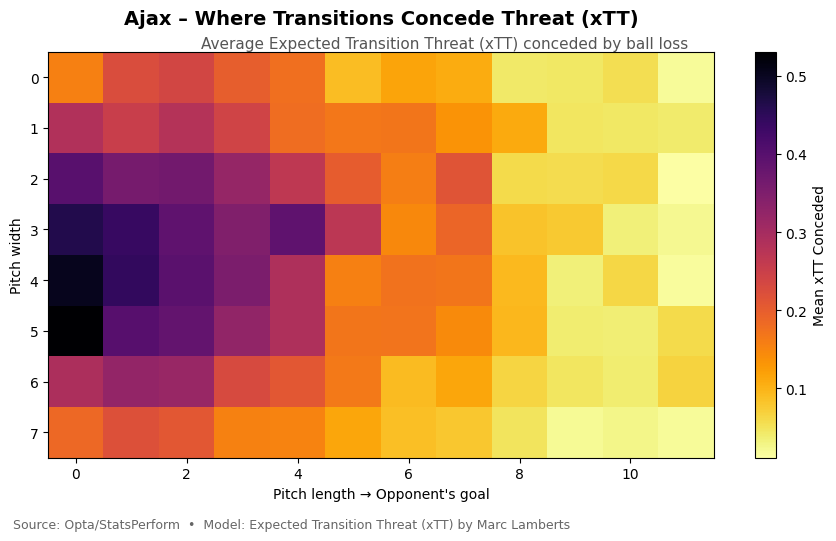

✅ Saved Ajax xTT conceded heatmap to: /Users/user/XTT_Heatmaps/Ajax_xTT_conceded_heatmap.png

🔥 Top 10 zones with highest xTT conceded:
 x_bin  y_bin  mean_xTT_conceded  events
   0.0    2.0           0.530744      90
   0.0    3.0           0.504210     248
   0.0    4.0           0.462321     232
   1.0    3.0           0.445464     211
   1.0    4.0           0.437869     192
   1.0    2.0           0.399899     123
   0.0    5.0           0.397472      43
   2.0    3.0           0.395120     122
   2.0    4.0           0.390611     104
   4.0    4.0           0.390586     126


In [10]:
# ============================================================
# 🗺️ xTT Conceded Location Heatmap for a Specific Team
# ============================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import os

# ============================================================
# 1️⃣ Configuration
# ============================================================

# Change these to your own local paths
teams_path = r"/Users/user/XG/Eredivisie 2025-2026 Matches.csv"
xTT_path   = r"/Users/user/XG/NL/xTT_per_event.csv"
out_dir    = r"/Users/user/XTT_Heatmaps"
os.makedirs(out_dir, exist_ok=True)

# Choose the team you want to visualize 
team_name = "Ajax"

# ============================================================
# 2️⃣ Load team mapping
# ============================================================

teams_df = pd.read_csv(teams_path)

team_map = dict(zip(
    teams_df["matchInfo/contestant/0/id"],
    teams_df["matchInfo/contestant/0/name"]
))
if "matchInfo/contestant/1/id" in teams_df.columns and "matchInfo/contestant/1/name" in teams_df.columns:
    team_map.update(dict(zip(
        teams_df["matchInfo/contestant/1/id"],
        teams_df["matchInfo/contestant/1/name"]
    )))

# Get the selected team's contestantId
team_ids = [tid for tid, name in team_map.items() if str(name).lower() == team_name.lower()]
if not team_ids:
    raise ValueError(f"Couldn't find '{team_name}' in team_map. Check spelling or casing.")
team_id = team_ids[0]

print(f"Visualizing xTT conceded locations for {team_name} (ID: {team_id})")

# ============================================================
# 3️⃣ Load xTT event data
# ============================================================

if not os.path.exists(xTT_path):
    raise FileNotFoundError(f"xTT file not found: {xTT_path}")

xTT_df = pd.read_csv(xTT_path)

if "def_team" not in xTT_df.columns or "x" not in xTT_df.columns:
    raise ValueError("xTT_per_event.csv is missing required columns.")

# ============================================================
# 4️⃣ Filter for defensive transitions for this team
# ============================================================

team_xTT = xTT_df[xTT_df["def_team"] == team_id].copy()
if team_xTT.empty:
    raise ValueError(f"No defensive xTT data found for team {team_name}")

# ============================================================
# 5️⃣ Bin spatially (12×8 pitch grid)
# ============================================================

x_bins = np.linspace(0, 100, 13)  # 0–100 normalized pitch length
y_bins = np.linspace(0, 100, 9)   # 0–100 normalized pitch width

team_xTT["x_bin"] = pd.cut(team_xTT["x"], bins=x_bins, labels=False, include_lowest=True)
team_xTT["y_bin"] = pd.cut(team_xTT["y"], bins=y_bins, labels=False, include_lowest=True)

heat_team = (
    team_xTT.groupby(["x_bin", "y_bin"])
    .agg(
        mean_xTT_conceded=("xTT", "mean"),
        events=("xTT", "size")
    )
    .reset_index()
)

# ============================================================
# 6️⃣ Create heatmap grid
# ============================================================

grid = np.full((8, 12), np.nan)
for _, r in heat_team.iterrows():
    xb, yb = int(r["x_bin"]), int(r["y_bin"])
    if 0 <= xb < 12 and 0 <= yb < 8:
        grid[7 - yb, xb] = r["mean_xTT_conceded"]  # invert y for pitch orientation

# ============================================================
# 7️⃣ Plot heatmap
# ============================================================

fig, ax = plt.subplots(figsize=(9, 6))
cmap = plt.cm.inferno_r
im = ax.imshow(grid, aspect="auto", cmap=cmap, interpolation="nearest")

# Titles and labels
ax.set_title(f"{team_name} – Where Transitions Concede Threat (xTT)",
             fontsize=14, fontweight="bold", pad=20)
fig.suptitle("Average Expected Transition Threat (xTT) conceded by ball loss",
             fontsize=11, y=0.83, color="#555555")

ax.set_xlabel("Pitch length → Opponent's goal")
ax.set_ylabel("Pitch width")

# Colorbar
cbar = fig.colorbar(im, ax=ax)
cbar.set_label("Mean xTT Conceded")

# Add a small source note
fig.text(0.02, 0.01,
         "Source: Opta/StatsPerform  •  Model: Expected Transition Threat (xTT) by Marc Lamberts",
         fontsize=9, color="#666666", ha="left")

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# ============================================================
# 8️⃣ Save figure
# ============================================================

out_path = os.path.join(out_dir, f"{team_name}_xTT_conceded_heatmap.png")
fig.savefig(out_path, dpi=300, bbox_inches="tight")
print(f"✅ Saved {team_name} xTT conceded heatmap to: {out_path}")

# ============================================================
# 9️⃣ Display numeric summary (top 10 hot zones)
# ============================================================

print("\n🔥 Top 10 zones with highest xTT conceded:")
print(
    heat_team.sort_values("mean_xTT_conceded", ascending=False)
              .head(10)
              .to_string(index=False)
)


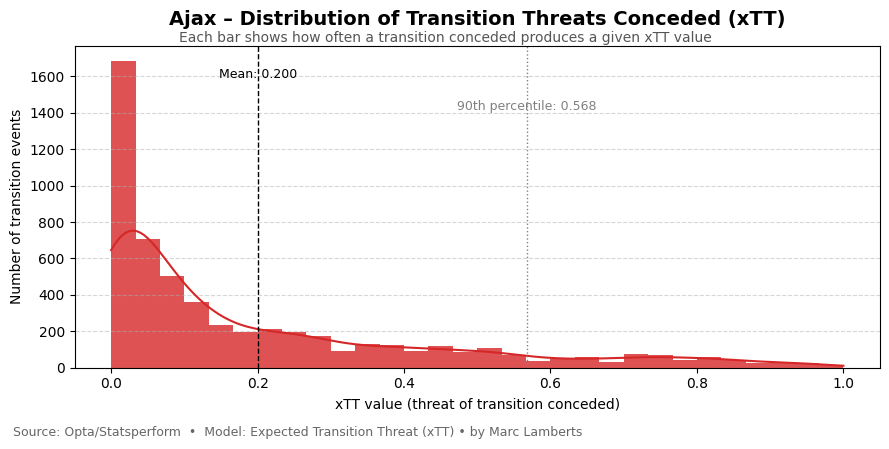

✅ Saved Ajax xTT distribution plot to: /Users/user/XTT_Distributions/Ajax_xTT_conceded_distribution.png


<Figure size 640x480 with 0 Axes>

In [11]:
# ============================================================
# 📈 Team – Distribution of Transition Danger (xTT Conceded)
# ============================================================

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os

# ============================================================
# 1️⃣ Configuration
# ============================================================

# 🔧 Change these paths for your setup
teams_path = r"/Users/user/XG/Eredivisie 2025-2026 Matches.csv"
xTT_path   = r"/Users/user/xG/NL/xTT_per_event.csv"
out_dir    = r"/Users/user/XTT_Distributions"
os.makedirs(out_dir, exist_ok=True)

# Choose the team
team_name = "Ajax"   # example; change to any name in your dataset

# ============================================================
# 2️⃣ Load data
# ============================================================

teams_df = pd.read_csv(teams_path)
xTT_df = pd.read_csv(xTT_path)

# --- Build mapping: contestantId → team name
team_map = dict(zip(
    teams_df["matchInfo/contestant/0/id"],
    teams_df["matchInfo/contestant/0/name"]
))
if "matchInfo/contestant/1/id" in teams_df.columns and "matchInfo/contestant/1/name" in teams_df.columns:
    team_map.update(dict(zip(
        teams_df["matchInfo/contestant/1/id"],
        teams_df["matchInfo/contestant/1/name"]
    )))

# --- Find the selected team's ID
team_ids = [tid for tid, name in team_map.items() if str(name).lower() == team_name.lower()]
if not team_ids:
    raise ValueError(f"Couldn't find '{team_name}' in team_map. Check spelling or casing.")
team_id = team_ids[0]

# ============================================================
# 3️⃣ Filter for this team's defensive transitions
# ============================================================

team_xTT = xTT_df[xTT_df["def_team"] == team_id].copy()
if team_xTT.empty:
    raise ValueError(f"No defensive xTT data found for {team_name}")

# ============================================================
# 4️⃣ Plot the distribution
# ============================================================

plt.figure(figsize=(9, 5))
sns.histplot(
    team_xTT["xTT"],
    bins=30,
    kde=True,
    color="#d62728",
    edgecolor=None,
    alpha=0.8
)

plt.title(f"{team_name} – Distribution of Transition Threats Conceded (xTT)",
          fontsize=14, fontweight="bold", pad=15)
plt.suptitle("Each bar shows how often a transition conceded produces a given xTT value",
             fontsize=10, color="#555555", y=0.82)

plt.xlabel("xTT value (threat of transition conceded)")
plt.ylabel("Number of transition events")
plt.grid(axis="y", linestyle="--", alpha=0.5)

# --- Annotate mean & 90th percentile
avg_val = team_xTT["xTT"].mean()
p90_val = team_xTT["xTT"].quantile(0.9)
plt.axvline(avg_val, color="black", linestyle="--", linewidth=1)
plt.text(avg_val, plt.ylim()[1]*0.9, f"Mean: {avg_val:.3f}", color="black", fontsize=9, ha="center")
plt.axvline(p90_val, color="gray", linestyle=":", linewidth=1)
plt.text(p90_val, plt.ylim()[1]*0.8, f"90th percentile: {p90_val:.3f}", color="gray", fontsize=9, ha="center")

plt.figtext(0.02, 0.01,
            "Source: Opta/Statsperform  •  Model: Expected Transition Threat (xTT) • by Marc Lamberts",
            fontsize=9, color="#666666", ha="left")

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# ============================================================
# 5️⃣ Save the figure locally
# ============================================================

out_path = os.path.join(out_dir, f"{team_name}_xTT_conceded_distribution.png")
plt.savefig(out_path, dpi=300, bbox_inches="tight")
print(f"✅ Saved {team_name} xTT distribution plot to: {out_path}")
